In [7]:
import os

from scipy . io import arff
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz


data = arff.loadarff ('../Data/COVID19andFLU.arff')
df = pd.DataFrame(data[0])

#print("Original arff data :")
#print(df.head())
string_columns = df.select_dtypes(include=["object"])
# Removing the b''
for column in string_columns:
    df[column] = df[column].str.decode("utf-8")
column_with_object = df.select_dtypes(include=["object"])
#print(df)
#print("STOP")

In [8]:
# Saving and Loading the CSV

# let ’s save this data frame in the CSV format
df.to_csv(r'../Results/COVID19andFLU.csv', index=False , header=True)

#print("The CSV file :")
os.system("head -n 5 ../Results//COVID19andFLU.csv")

# you can load the csv data easily
df = pd.read_csv("../Results/COVID19andFLU.csv")

# preview the first 5 lines of the loaded data
#print("Read from the CSV file :")
#print(df.head())

Diagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CTscanResults,XrayResults,Diarrhea,Fever,Coughing,SoreThroat,NauseaVomitting,Fatigue,RenalDisease,diabetes
H1N1,67.0,f,,,,?,?,?,yes,yes,no,?,no,?,?
H1N1,29.0,m,,,,?,?,?,?,?,?,?,?,?,?
H1N1,22.0,f,,,,?,?,?,?,?,?,?,?,?,?
H1N1,20.0,f,,,,?,?,?,yes,yes,no,?,yes,no,no


Changing all object column except Diagnosis

In [9]:
df = pd.get_dummies(df, columns=list(column_with_object.iloc[:, 1:].columns))
new_list = list()
for element in list(column_with_object.iloc[:, 1:].columns):
    new_list.append(element + "_?")
df = df.drop(columns=new_list)



Replacing NaN values by the average of the column

In [10]:
column_with_number = df.select_dtypes(include=["int64", "float64"])
for column in column_with_number:
    df[column].fillna((df[column].mean()), inplace=True)


Transform diagnostic into number for the decision tree

In [11]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return df_mod

df2 = encode_target(df, "Diagnosis")


Decision tree

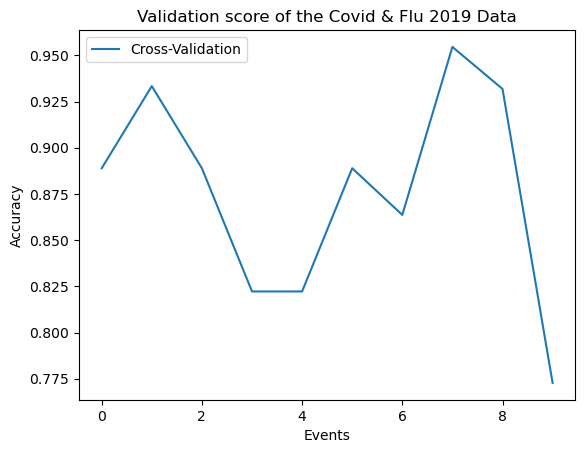

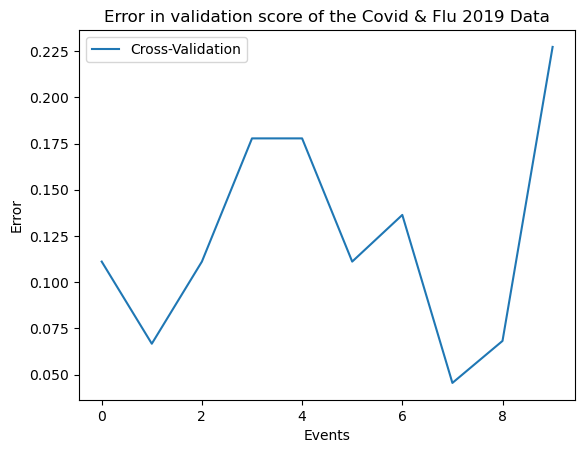

Score Validation: [0.88888889 0.93333333 0.88888889 0.82222222 0.82222222 0.88888889
 0.86363636 0.95454545 0.93181818 0.77272727]
Accuracy Score: 0.9192825112107623
Test Score: 0.9192825112107623
Train Score: 0.9894128970163619
Test Error: 0.08071748878923768
Train Error: 0.010587102983638075


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import graphviz

features = list(df2.columns[1:-1])
y = df2["Target"]
X = df2[features]
var_train, var_test, res_train, res_test = train_test_split(X, y, test_size = 0.3)
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(var_train, res_train)
res_pred = decision_tree.predict(var_test)
score = accuracy_score(res_test, res_pred)
train_score = decision_tree.score(var_train, res_train)
test_score = decision_tree.score(var_test, res_test)
score_val = cross_val_score(decision_tree, var_test, res_test, cv=10)

plt.plot(score_val, label="Cross-Validation")
plt.xlabel('Events')
plt.ylabel('Accuracy')
plt.title('Validation score of the Covid & Flu 2019 Data')
plt.legend(loc='best')
plt.savefig('../Results/Images/ScoreValidation.png', dpi=500)
plt.show()

plt.plot(1 - score_val, label="Cross-Validation")
plt.xlabel('Events')
plt.ylabel('Error')
plt.title('Error in validation score of the Covid & Flu 2019 Data')
plt.legend(loc='best')
plt.savefig('../Results/Images/ErrorInValidation.png', dpi=500)
plt.show()

print('Score Validation:', score_val)
print('Accuracy Score:', score)
print('Test Score:', test_score)
print('Train Score:', train_score)
print('Test Error:', 1-test_score)
print('Train Error:', 1-train_score)

Creating the PNG of the tree

In [13]:
import subprocess

def visualize_tree(tree, feature_names, class_names, file_name):
    with open(f"../Results/{file_name}.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names, class_names=class_names, filled=True, rounded=True,
                        special_characters=True)

    command = ["dot", "-Tpng", f"../Results/{file_name}.dot", "-o", f"../Results/Images/DecisionTree.png"]
    try:
        subprocess.check_call(command)
    except:
        print("fail")
visualize_tree(decision_tree, features, df2["Diagnosis"].unique(), "result")